In [2]:
import json
import matplotlib.pyplot as plt

## Load case.json

In [3]:
caseList = list()
with open("case.json", "r", encoding="utf-8") as f:
    for idx, line in enumerate(f.readlines()):
        if idx % 4 == 0:
            continue
        if idx % 4 == 1:
            content = line.strip().strip("预测：")
            pred = json.loads(content)
        if idx % 4 == 2:
            content = line.strip().strip("答案：")
            golden = json.loads(content)
            caseList.append((pred, golden))

In [4]:
print(len(caseList))

408


## Draw distribution of each event type in golden

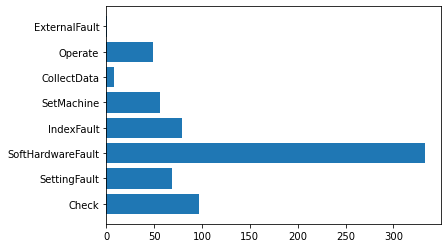

In [5]:
eventCnt = dict()
for predItem, goldenItem in caseList:
    for event in goldenItem["event_list"]:
        eventType = event["trigger"][0]
        if eventType not in eventCnt:
            eventCnt[eventType] = 0
        eventCnt[eventType] += 1
plt.barh(list(eventCnt.keys()), eventCnt.values())  
plt.show() 

## Draw precision and recall of each event type in golden

Precision


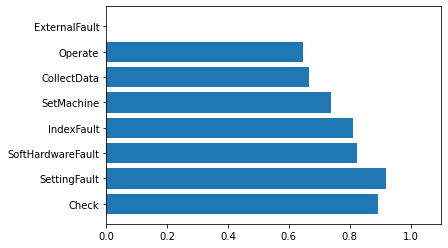

Recall


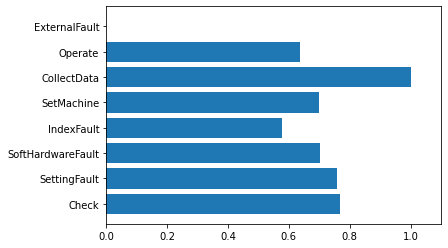

In [11]:
tp, fp, fn = dict(), dict(), dict()
for eventType in eventCnt:
    tp[eventType] = fp[eventType] = fn[eventType] = 0.0
for predItem, goldenItem in caseList:
    predTriggerList = [event["trigger"] for event in predItem["event_list"]]
    goldenTriggerList = [event["trigger"] for event in goldenItem["event_list"]]
    for predTrigger in predTriggerList:
        if predTrigger in goldenTriggerList:
            tp[predTrigger[0]] += 1
        else:
            fp[predTrigger[0]] += 1
    for goldenTrigger in goldenTriggerList:
        if goldenTrigger not in predTriggerList:
            fn[predTrigger[0]] += 1
precision, recall = dict(), dict()
for eventType in eventCnt:
    precision[eventType] = tp[eventType] / (tp[eventType] + fp[eventType]) if tp[eventType] + fp[eventType] != 0 else 0
    recall[eventType] = tp[eventType] / (tp[eventType] + fn[eventType]) if tp[eventType] + fn[eventType] != 0 else 0
print("Precision")
plt.barh(list(precision.keys()), precision.values())
plt.xlim([0, 1.1])
plt.show() 
print("Recall")
plt.barh(list(recall.keys()), recall.values())
plt.xlim([0, 1.1])
plt.show() 

## Split wrong case into: under trigger, over trigger, span mismatch and wrong type

In [20]:
def findSpan(origin, spanList):
    for span in spanList:
        if span[1] <= origin[2] and origin[1] <= span[2]:
            return span
    return None

ut, ot, sm, wt = list(), list(), list(), list() # under trigger, over trigger ,span mismatch, wrong type
for predItem, goldenItem in caseList:
    predSpanList = [(event["trigger"][0], event["trigger"][1], event["trigger"][1] + len(event["trigger"][2]), event["trigger"][2]) for event in predItem["event_list"]]
    goldenSpanList = [(event["trigger"][0], event["trigger"][1], event["trigger"][1] + len(event["trigger"][2]), event["trigger"][2]) for event in goldenItem["event_list"]]
    for predSpan in predSpanList:
        target = findSpan(predSpan, goldenSpanList)
        if target is not None:
            if predSpan[1] == target[1] and predSpan[2] == target[2]: # span match
                if predSpan[0] == target[0]: # tp
                    pass
                else:
                    wt.append((predSpan, target, predItem["text"]))
            else:
                sm.append((predSpan, target, predItem["text"]))
        else:
            ot.append((predSpan, target, predItem["text"]))
    for goldenSpan in goldenSpanList:
        target = findSpan(goldenSpan, predSpanList)
        if target is None:
            ut.append((target, goldenSpan, goldenItem["text"])) 

In [21]:
print("under trigger")
print(len(ut))
print("over trigger")
print(len(ot))
print("span mismatch")
print(len(sm))
print("wrong type")
print(len(wt))

under trigger
143
over trigger
32
span mismatch
52
wrong type
23


In [22]:
ut[0]

(None, ('SetMachine', 1, 3, '修改'), ' 修改为1之后定标正常')

In [23]:
ot[0]

(('Operate', 46, 48, '复现'),
 None,
 '通过分析BTS3205E 在V100R010C10SPC150和V100R011C10版本上复现相同操作的一键式日志，')

In [24]:
sm[0]

(('SoftHardwareFault', 15, 21, 'attach'),
 ('SoftHardwareFault', 15, 17, 'at'),
 '空口加密算法不一致导致用户无法attach')

In [25]:
wt[0]

(('SoftHardwareFault', 17, 19, '定义'),
 ('SettingFault', 17, 19, '定义'),
 'RRUCHAIN链环号中的配置信息定义错误导致XX局点LTE-FDD的Lampsite站点BBU CPRI线速率协商异常告警处理案例')